In [ ]:
! pip install pandas numpy matplotlib scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
# dataset -> https://www.kaggle.com/competitions/store-sales-time-series-forecasting
df = pd.read_csv('./csv/train.csv', parse_dates=['date'])
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
store_id = df['store_nbr'].unique()[0]
family_id = df['family'].unique()[0]

df_filtered = df[(df['store_nbr'] == store_id) & (df['family'] == family_id)].copy()
df_filtered = df_filtered.sort_values('date')
df_filtered.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0


In [5]:
# load holidays dataset
holidays = pd.read_csv('./csv/holidays_events.csv', parse_dates=['date'])

# national holidays
holidays = holidays[holidays['locale'] == 'National']

# merge with filtered data of store/family
df_filtered = pd.merge(df_filtered, holidays[['date','type']], on='date', how='left')

# binary column, 1 if is holiday else 0
df_filtered['is_holiday'] = df_filtered['type'].notna().astype(int)

# remove 'type' column if is not necessary anymore
df_filtered.drop(columns=['type'], inplace=True)

df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek
df_filtered['month'] = df_filtered['date'].dt.month
df_filtered['day'] = df_filtered['date'].dt.day


df_filtered.head(10)

,id,date,store_nbr,family,sales,onpromotion,is_holiday,day_of_week,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,1,1
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,0,2,1,2
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,0,3,1,3
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,0,4,1,4
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,1,5,1,5
5,8910,2013-01-06,1,AUTOMOTIVE,2.0,0,0,6,1,6
6,10692,2013-01-07,1,AUTOMOTIVE,0.0,0,0,0,1,7
7,12474,2013-01-08,1,AUTOMOTIVE,2.0,0,0,1,1,8
8,14256,2013-01-09,1,AUTOMOTIVE,2.0,0,0,2,1,9
9,16038,2013-01-10,1,AUTOMOTIVE,2.0,0,0,3,1,10


In [6]:
# window with n previous steps 
class TimeSeriesWindow(BaseEstimator, TransformerMixin):
    def __init__(self, window_size = 7):
        self.window_size = window_size

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = []
        for i in range (self.window_size, len(X)):
            window = X.iloc[i - self.window_size:i].values.flatten()
            X_transformed.append(window)
        return np.array(X_transformed)

In [7]:
# preparing X and y
features = ['sales', 'day_of_week', 'month', 'day', 'is_holiday']
target = df_filtered['sales'].values

X = df_filtered[features]
y = df_filtered['sales'].values

window_size = 7

X_window = TimeSeriesWindow(window_size=window_size).fit_transform(X)
y_window = y[window_size:]

In [18]:
# Number of splits
outer_cv = TimeSeriesSplit(n_splits=5)

# MLP hiperparameters that will be sought in internal cross-validation
param_grid = {
    'mlp__hidden_layer_sizes': [(30,), (20,), (20,10)], #ReLu is the default
    'mlp__alpha': [0.0001, 0.001], # weight decay
    'mlp__learning_rate_init':[0.001, 0.01],
}

# normalization pipeline
pipeline = Pipeline ([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPRegressor(max_iter=500, random_state=42))
])

In [19]:
mse_scores = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_window)):
    X_train, X_test = X_window[train_idx], X_window[test_idx]
    y_train, y_test = y_window[train_idx], y_window[test_idx]

    inner_cv = TimeSeriesSplit(n_splits=3)

    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test) # scalar output
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # store chart predictions
    if fold == 0:
        all_y_test = y_test
        all_y_pred = y_pred
    else:
        all_y_test = np.concatenate([all_y_test, y_test])
        all_y_pred = np.concatenate([all_y_pred, y_pred])


    print(f"Fold {fold + 1}: MSE = {mse:.2f}, \n Best Params: {grid_search.best_params_}")

c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

Fold 1: MSE = 6.25, 
 Best Params: {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (20,), 'mlp__learning_rate_init': 0.001}


c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

Fold 2: MSE = 6.99, 
 Best Params: {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (20,), 'mlp__learning_rate_init': 0.001}


c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

Fold 3: MSE = 9.05, 
 Best Params: {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (20,), 'mlp__learning_rate_init': 0.001}


c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

Fold 4: MSE = 10.30, 
 Best Params: {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (20,), 'mlp__learning_rate_init': 0.001}


c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ryanq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

Fold 5: MSE = 8.13, 
 Best Params: {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (30,), 'mlp__learning_rate_init': 0.001}


In [20]:
print(f"Média de MSE nos folds: {np.mean(mse_scores):.2f}")


Média de MSE nos folds: 8.14


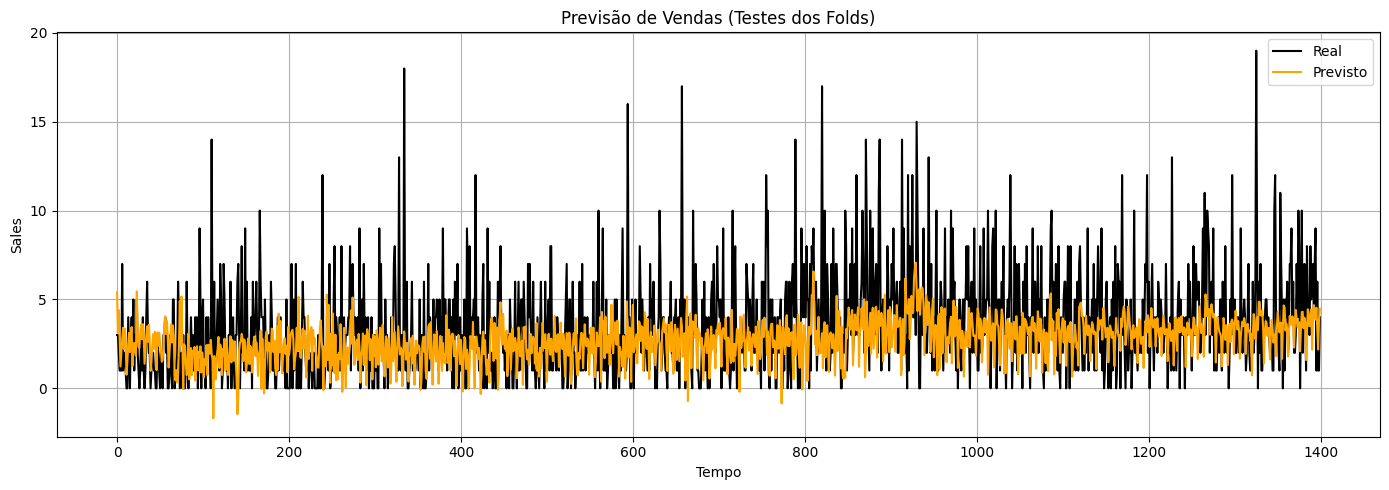

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(all_y_test, label='Real', color='black')
plt.plot(all_y_pred, label='Previsto', color='orange')
plt.title('Previsão de Vendas (Testes dos Folds)')
plt.xlabel('Tempo')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


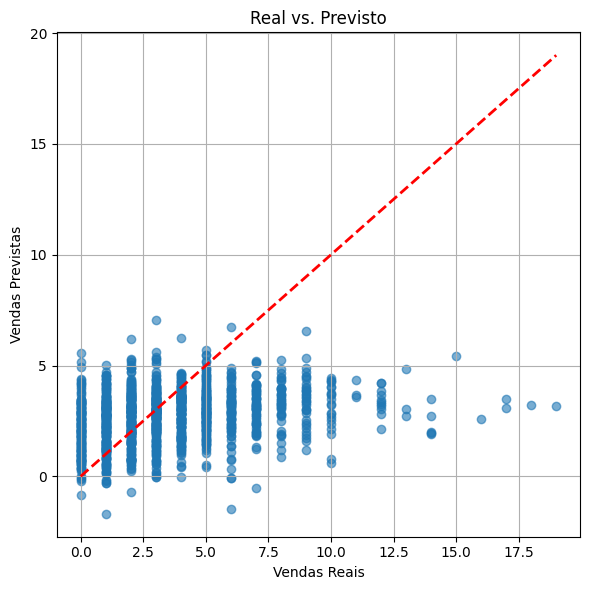

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(all_y_test, all_y_pred, alpha=0.6)
plt.plot([all_y_test.min(), all_y_test.max()],
         [all_y_test.min(), all_y_test.max()],
         'r--', lw=2)
plt.title('Real vs. Previsto')
plt.xlabel('Vendas Reais')
plt.ylabel('Vendas Previstas')
plt.grid(True)
plt.tight_layout()
plt.show()


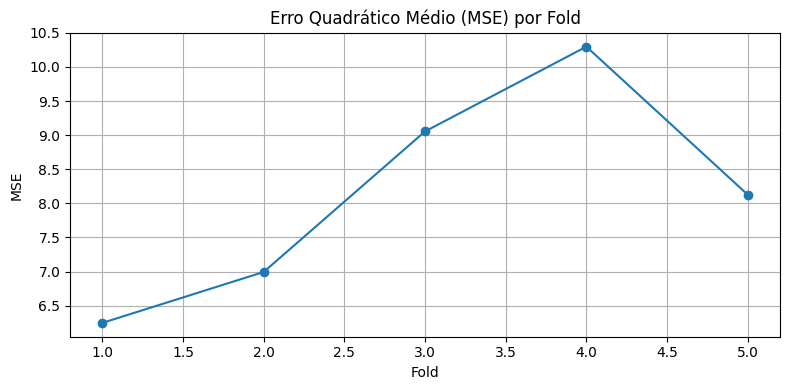

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o')
plt.title('Erro Quadrático Médio (MSE) por Fold')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.grid(True)
plt.tight_layout()
plt.show()
